    1) Slice Time(SPM)
    2) Trimming (nipy)
    3) Motion Correction (FSL)
    4) Brain Extraction (ANTs)
    5) Coregistration (rigid) (ANTs)
    6) Normalization to MNI (non-linear) (ANTs)
    7) Low-pass/High-Frequency filtering (nilearn)
    8) Smoothing (FSL)
    9) Downsampling to INT16 precision to save space (nibabel)

In [1]:
from nipype.pipeline.engine import Node, Workflow
from os.path import abspath as abs
from os.path import join as opj

220127-06:46:56,15 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


In [2]:
anat_file = abs('./data/ucla/sub-10159/anat/sub-10159_T1w.nii.gz')
func_file = abs('./data/ucla/sub-10159/func/sub-10159_task-rest_bold.nii.gz')

MNItemplate = abs('./data/templates/MNI152_T1_2mm_brain.nii.gz')
MNImask = abs('./data/templates/MNI152_T1_2mm_brain_mask.nii.gz')
MNItemplatehasskull = ('./data/templates/MNI152_T1_2mm.nii.gz')

bet_ants_template = abs('./data/templates/OASIS_template.nii.gz')
bet_ants_prob_mask = abs('./data/templates/OASIS_BrainCerebellumProbabilityMask.nii.gz')
bet_ants_registration_mask = abs('./data/templates/OASIS_BrainCerebellumRegistrationMask.nii.gz')

THREADS = 4

In [3]:
preproc = Workflow(name='UCLA_Preprocessing', base_dir=abs('./output/'))

In [4]:
from nipype.algorithms.misc import Gunzip

gunzip_anat = Node(Gunzip(), name='Gunzip_Anatomical')
gunzip_func = Node(Gunzip(), name='Gunzip_Functional')

In [5]:
# Slice Timing

# Slice time correction
# Repetion Time(TR) = 2
# 34 slices per volume
# accusition time = TR - (TR/34)
# choosing the reference slice as the median

from nipype.interfaces.spm import SliceTiming

num_slices = 34
TR = 2
TA = TR - (TR / num_slices)
slice_order = list(range(1, num_slices+1, 2)) + list(range(2, num_slices+1, 2))

slicetime = Node(SliceTiming(num_slices=num_slices,
                             ref_slice=int(num_slices / 2),
                             slice_order=slice_order,
                             time_repetition=TR,
                             time_acquisition=TA),
                 name='Slice_Time_Correction')

In [6]:
# Triming

from nipype.interfaces.nipy.preprocess import Trim

trim = Node(Trim(begin_index=5), name='Magnetic_Saturation_Trim')

In [7]:
# Motion Correction

from nipype.interfaces.fsl import MCFLIRT

realign_fsl = Node(MCFLIRT(cost='mutualinfo', mean_vol=True), name='Motion_Correction')

In [8]:
# Coregisitration after alignment

from nipype.interfaces.fsl.maths import MeanImage

mean_epi = Node(MeanImage(dimension='T'), name='Mean_EPI')

In [9]:
# Brain Extraction

from nipype.interfaces.ants.segmentation import BrainExtraction

brain_extraction_ants = Node(BrainExtraction(dimension=3,
                                             use_floatingpoint_precision=1,
                                             num_threads=THREADS,
                                             brain_probability_mask=bet_ants_prob_mask,
                                             keep_temporary_files=1,
                                             brain_template=bet_ants_template,
                                             extraction_registration_mask=bet_ants_registration_mask,
                                             out_prefix='bet'),
                             name='Brain_Extraction')

In [10]:
# Coregistration

from nipype.interfaces.ants import Registration

coregistration = Node(Registration(), name='Coregistration')
coregistration.inputs.float = False
coregistration.inputs.output_transform_prefix = 'meanEpi2highres'
coregistration.inputs.transforms = ['Rigid']
coregistration.inputs.transform_parameters = [(0.1,), (0.1,)]
coregistration.inputs.number_of_iterations = [[1000, 500, 250, 100]]
coregistration.inputs.dimension = 3
coregistration.inputs.num_threads = THREADS
coregistration.inputs.write_composite_transform = True
coregistration.inputs.collapse_output_transforms = True
coregistration.inputs.metric = ['MI']
coregistration.inputs.metric_weight = [1]
coregistration.inputs.radius_or_number_of_bins = [32]
coregistration.inputs.sampling_strategy = ['Regular']
coregistration.inputs.sampling_percentage = [0.25]
coregistration.inputs.convergence_threshold = [1e-08]
coregistration.inputs.convergence_window_size = [10]
coregistration.inputs.smoothing_sigmas = [[3, 2, 1, 0]]
coregistration.inputs.sigma_units = ['mm']
coregistration.inputs.shrink_factors = [[4, 3, 2, 1]]
coregistration.inputs.use_estimate_learning_rate_once = [True]
coregistration.inputs.use_histogram_matching = [False]
coregistration.inputs.initial_moving_transform_com = True
coregistration.inputs.output_warped_image = True
coregistration.inputs.winsorize_lower_quantile = 0.01
coregistration.inputs.winsorize_upper_quantile = 0.99

In [11]:
# normalization

normalization = Node(Registration(), name='Normalization')
normalization.inputs.float = False
normalization.inputs.collapse_output_transforms = True
normalization.inputs.convergence_threshold = [1e-06]
normalization.inputs.convergence_window_size = [10]
normalization.inputs.dimension = 3
normalization.inputs.fixed_image = MNItemplate
normalization.inputs.initial_moving_transform_com = True
normalization.inputs.metric = ['MI', 'MI', 'CC']
normalization.inputs.metric_weight = [1.0]*3
normalization.inputs.number_of_iterations = [[1000, 500, 250, 100],
                                             [1000, 500, 250, 100],
                                             [100, 70, 50, 20]]
normalization.inputs.num_threads = THREADS
normalization.inputs.output_transform_prefix = 'anat2template'
normalization.inputs.output_inverse_warped_image = True
normalization.inputs.output_warped_image = True
normalization.inputs.radius_or_number_of_bins = [32, 32, 4]
normalization.inputs.sampling_percentage = [0.25, 0.25, 1]
normalization.inputs.sampling_strategy = ['Regular', 'Regular', 'None']
normalization.inputs.shrink_factors = [[8, 4, 2, 1]]*3
normalization.inputs.sigma_units = ['vox']*3
normalization.inputs.smoothing_sigmas = [[3, 2, 1, 0]]*3
normalization.inputs.transforms = ['Rigid', 'Affine', 'SyN']
normalization.inputs.transform_parameters = [(0.1,), (0.1,), (0.1, 3.0, 0.0)]
normalization.inputs.use_histogram_matching = True
normalization.inputs.winsorize_lower_quantile = 0.005
normalization.inputs.winsorize_upper_quantile = 0.995
normalization.inputs.write_composite_transform = True

In [12]:
# Apply transformation

from nipype.interfaces.utility import Merge
from nipype.interfaces.ants import Registration, ApplyTransforms

merge_transforms = Node(Merge(2), iterfield=['in2'], name='Merge_Transforms')

apply_transforms = Node(ApplyTransforms(), iterfield=['input_image'], name='Apply_Transforms')
apply_transforms.inputs.input_image_type = 3
apply_transforms.inputs.float = False
apply_transforms.inputs.num_threads = THREADS
apply_transforms.inputs.environ = {}
apply_transforms.inputs.interpolation = 'BSpline'
apply_transforms.inputs.invert_transform_flags = [False, False]
apply_transforms.inputs.reference_image = MNItemplate

In [14]:
# Smoothing

from nipype.interfaces.fsl.utils import Smooth

smooth = Node(Smooth(fwhm=4), name='Smoothing_4mm')

In [15]:
# Low Pass Temporal Filtering

from interfaces import Filter_In_Mask

lp_filter = Node(Filter_In_Mask(), name='Low_Pass_Temporal_Filter')
lp_filter.inputs.mask = MNImask
lp_filter.inputs.sampling_rate = 2
lp_filter.inputs.high_pass_cutoff = 0
lp_filter.inputs.low_pass_cutoff = 0.25

In [13]:
# Downlsampling

from interfaces import Down_Sample_Precision

down_samp = Node(Down_Sample_Precision(), name='Down_Sampling')

In [16]:
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink

experiment_dir = abs('./output')
output_dir = 'datasink'
working_dir = 'workingdir'

subject_list = ['50020', '50056']

# list of session identifiers
task_list = ['rest']

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']), name="infosource")
infosource.iterables = [('subject_id', subject_list), ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'func', 'sub-{subject_id}_task-{task_name}_bold.nii.gz')
templates = {'anat': anat_file,
             'func': func_file}

selectfiles = Node(SelectFiles(templates, base_directory=abs('./data/ucla')), name="Select_Files")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir, container=output_dir), name="Datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]

datasink.inputs.substitutions = substitutions

preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')])])

preproc.connect([((selectfiles, gunzip_anat, [('anat', 'in_file')]))])
preproc.connect([((selectfiles, gunzip_func, [('func', 'in_file')]))])

In [17]:
preproc.connect([
        (gunzip_func, slicetime, [('out_file', 'in_files')]),
        (slicetime, trim, [('timecorrected_files', 'in_file')]), 
        (trim, realign_fsl, [('out_file', 'in_file')]),
        (realign_fsl, mean_epi, [('out_file', 'in_file')]),
        (gunzip_anat, brain_extraction_ants, [('out_file', 'anatomical_image')]),
        (brain_extraction_ants, coregistration, [('BrainExtractionBrain', 'fixed_image')]),
        (mean_epi, coregistration, [('out_file', 'moving_image')]),
        (brain_extraction_ants, normalization, [('BrainExtractionBrain', 'moving_image')]),
        (coregistration, merge_transforms, [('composite_transform', 'in2')]),
        (normalization, merge_transforms, [('composite_transform', 'in1')]),
        (merge_transforms, apply_transforms, [('out', 'transforms')]),
        (realign_fsl, apply_transforms, [('out_file', 'input_image')]),
        (lp_filter, smooth, [('out_file', 'in_file')]),
        (smooth, down_samp, [('smoothed_file', 'in_file')]),
        (apply_transforms, lp_filter, [('output_image', 'in_file')])
    ])

220127-06:46:57,385 nipype.workflow INFO:
	 Generated workflow graph: /output/UCLA_Preprocessing/graph.png (graph2use=colored, simple_form=True).


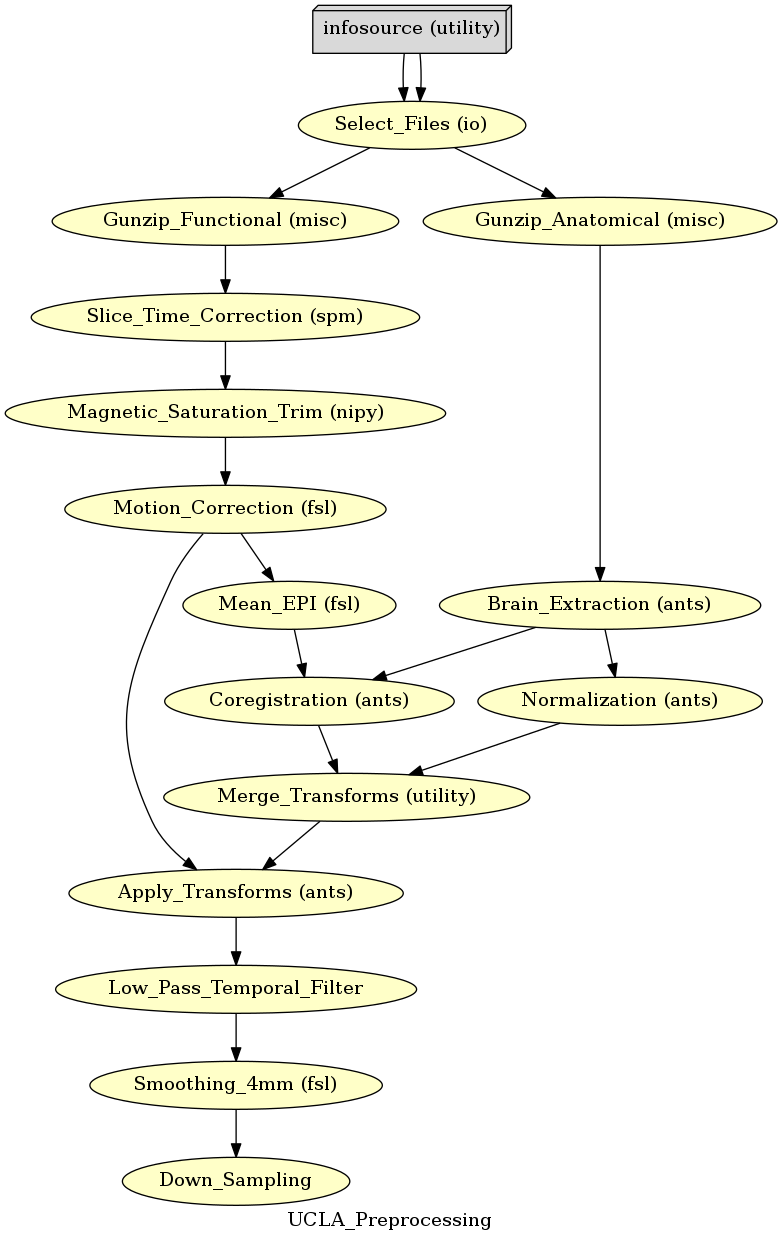

In [18]:
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename='./output/UCLA_Preprocessing/graph.png', width=750)

220127-06:46:58,126 nipype.workflow INFO:
	 Generated workflow graph: /output/UCLA_Preprocessing/graph.png (graph2use=flat, simple_form=True).


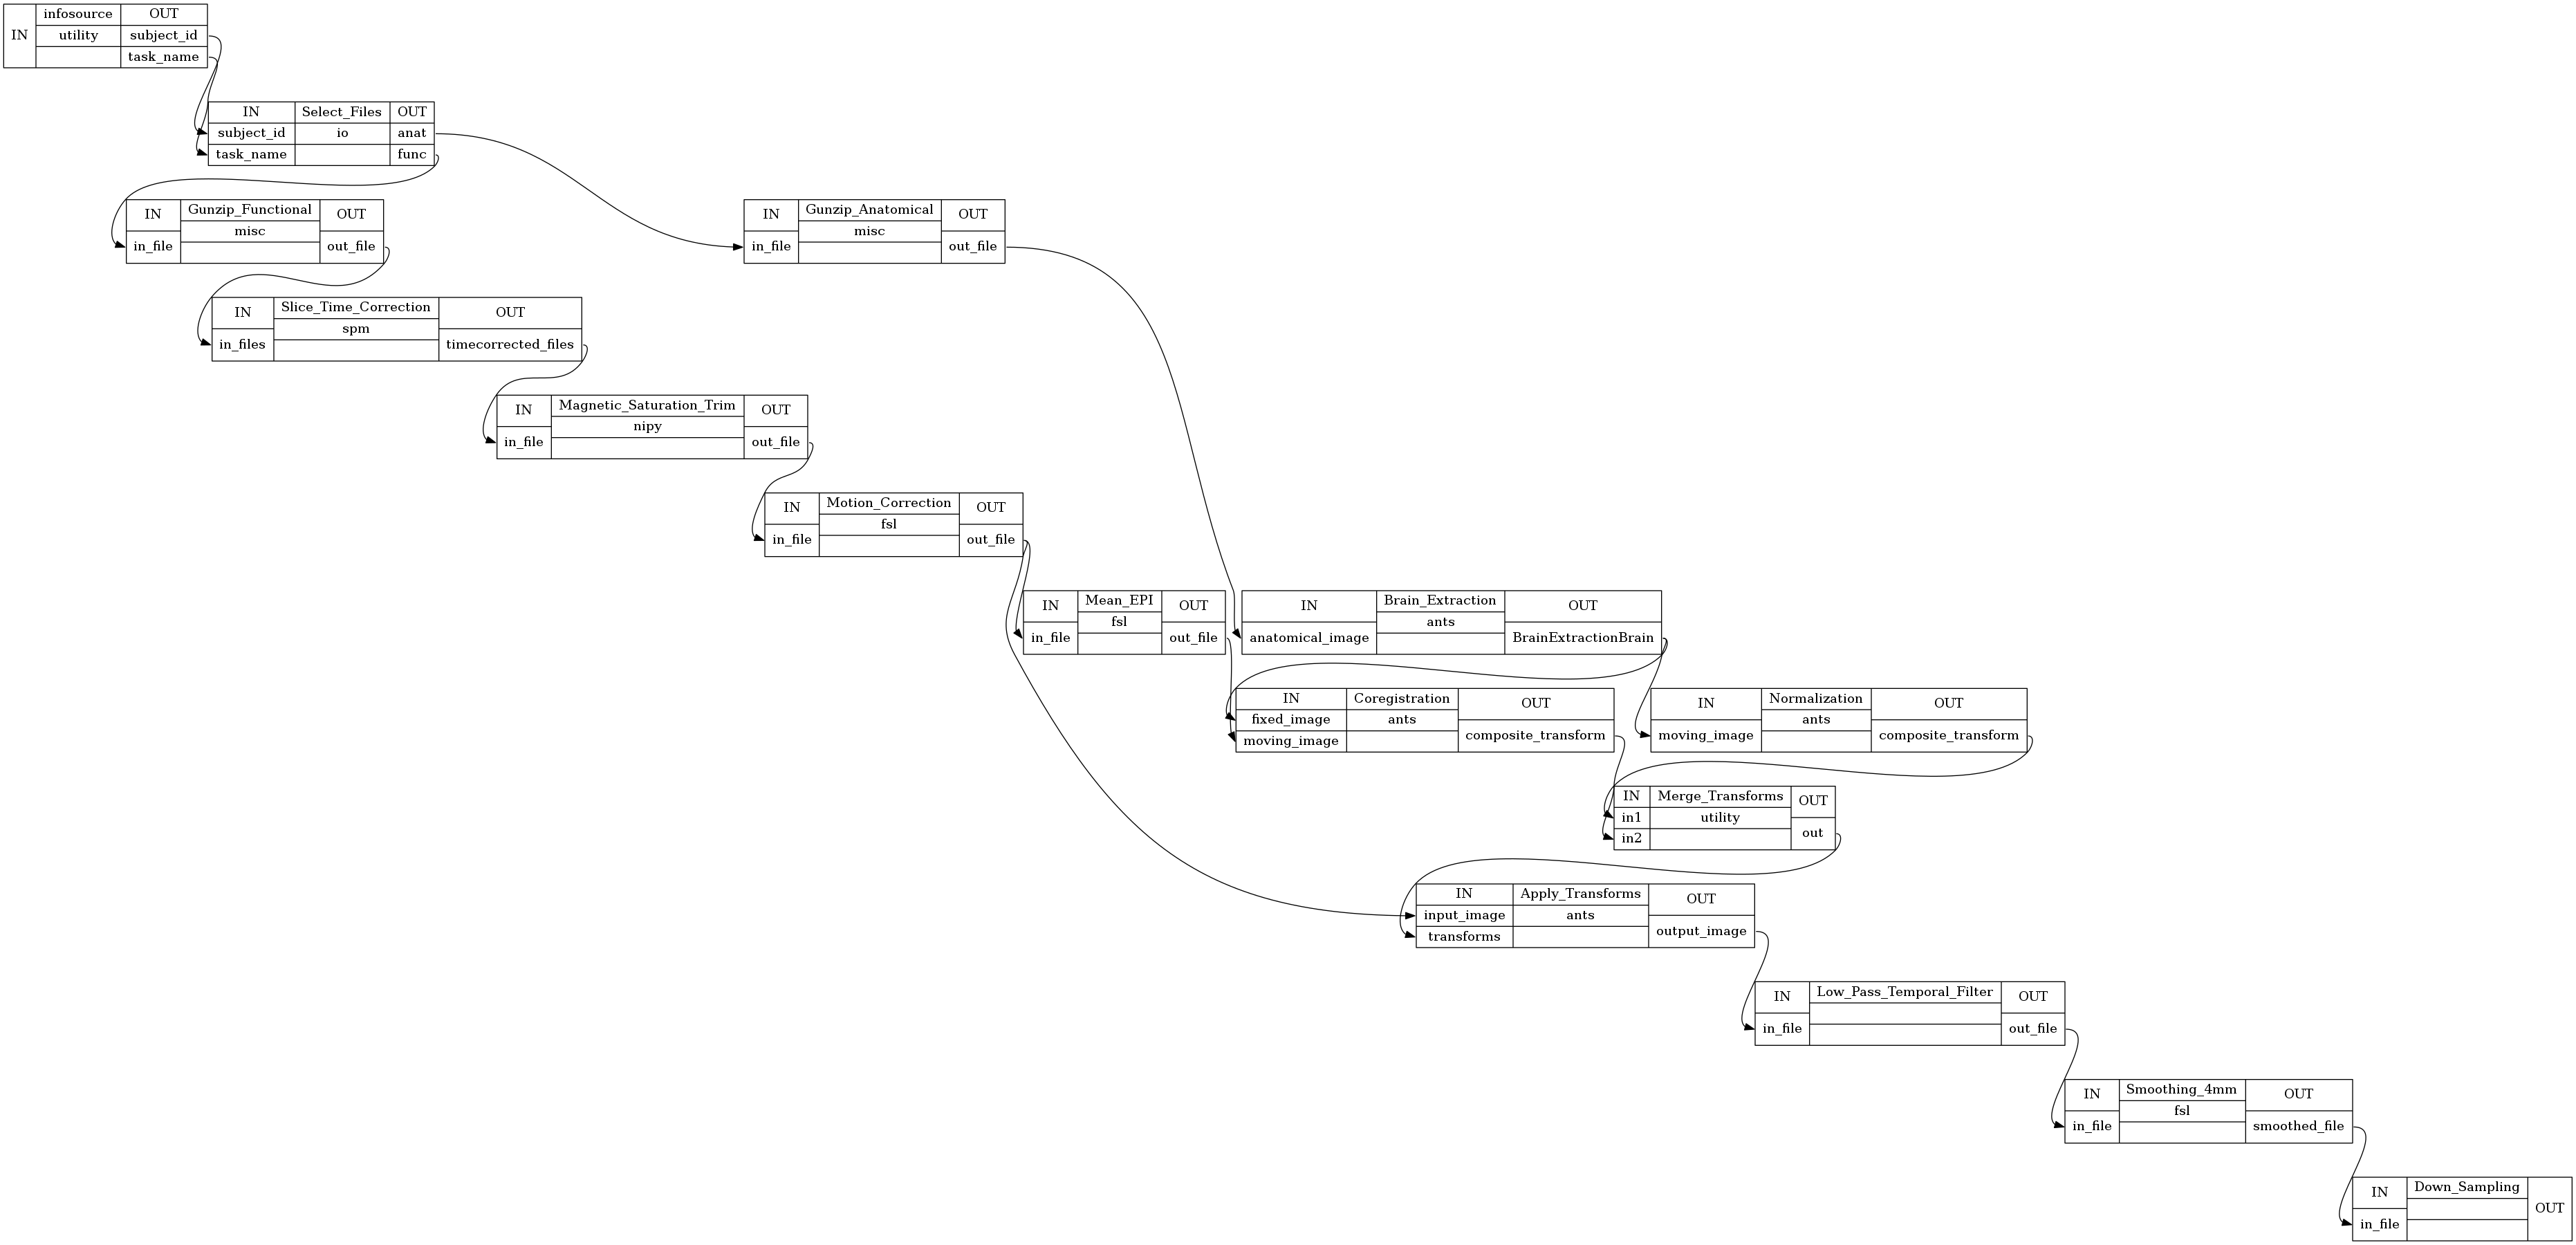

In [19]:
from IPython.display import Image

preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename='/output/UCLA_Preprocessing/graph_detailed.png')

In [20]:
%%time
preproc.run('MultiProc', plugin_args={'n_procs': THREADS})

220127-06:46:58,219 nipype.workflow INFO:
	 Workflow UCLA_Preprocessing settings: ['check', 'execution', 'logging', 'monitoring']
220127-06:46:58,404 nipype.workflow INFO:
	 Running in parallel.
220127-06:46:58,411 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 4/4.
220127-06:46:58,578 nipype.workflow INFO:
	 [Node] Setting-up "UCLA_Preprocessing.Select_Files" in "/output/UCLA_Preprocessing/_subject_id_50056_task_name_rest/Select_Files".
220127-06:46:58,586 nipype.workflow INFO:
	 [Node] Setting-up "UCLA_Preprocessing.Select_Files" in "/output/UCLA_Preprocessing/_subject_id_50020_task_name_rest/Select_Files".
220127-06:46:58,724 nipype.workflow INFO:
	 [Node] Running "Select_Files" ("nipype.interfaces.io.SelectFiles")
220127-06:46:58,731 nipype.workflow INFO:
	 [Node] Running "Select_Files" ("nipype.interfaces.io.SelectFiles")
220127-06:46:58,834 nipype.workflow INFO:
	 [Node] Finished "UCLA_Preprocessing.Select_File

220127-06:49:26,114 nipype.workflow INFO:
	 [Node] Finished "UCLA_Preprocessing.Motion_Correction".
220127-06:49:26,565 nipype.workflow INFO:
	 [Job 19] Completed (UCLA_Preprocessing.Motion_Correction).
220127-06:49:26,567 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 3 jobs ready. Free memory (GB): 3.25/3.45, Free processors: 3/4.
                     Currently running:
                       * UCLA_Preprocessing.Motion_Correction
220127-06:49:26,644 nipype.workflow INFO:
	 [Node] Setting-up "UCLA_Preprocessing.Mean_EPI" in "/output/UCLA_Preprocessing/_subject_id_50020_task_name_rest/Mean_EPI".
220127-06:49:26,720 nipype.workflow INFO:
	 [Node] Running "Mean_EPI" ("nipype.interfaces.fsl.maths.MeanImage"), a CommandLine Interface with command:
fslmaths /output/UCLA_Preprocessing/_subject_id_50020_task_name_rest/Motion_Correction/asub-50020_task-rest_bold_trim_mcf.nii.gz -Tmean /output/UCLA_Preprocessing/_subject_id_50020_task_name_rest/Mean_EPI/asub-50020_task-rest_bold_trim

220127-06:49:36,595 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 4/4.
220127-06:49:38,577 nipype.workflow INFO:
	 ***********************************
220127-06:49:38,578 nipype.workflow ERROR:
	 could not run node: UCLA_Preprocessing.Brain_Extraction.a1
220127-06:49:38,579 nipype.workflow INFO:
	 crashfile: /home/neuro/nipype_tutorial/crash-20220127-064934-neuro-Brain_Extraction.a1-3e3a43d4-670e-4cff-956a-8ea9056dc9c1.pklz
220127-06:49:38,580 nipype.workflow ERROR:
	 could not run node: UCLA_Preprocessing.Brain_Extraction.a0
220127-06:49:38,581 nipype.workflow INFO:
	 crashfile: /home/neuro/nipype_tutorial/crash-20220127-064936-neuro-Brain_Extraction.a0-6dec5d86-4ed7-401c-9276-206e920426d9.pklz
220127-06:49:38,581 nipype.workflow INFO:
	 ***********************************


RuntimeError: Workflow did not execute cleanly. Check log for details